In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)

In [2]:
#creating a function to find SMA for n period 
def sma(data,period):
      return data.rolling(period).mean()

In [3]:
# start='2023-06-20'
# end='2023-08-12'
# data=yf.download("CL=F", start, end, interval="30m")

In [4]:
symbol = 'MES=F'
start = '2023-06-20'
end = '2023-08-14'
data=yf.download(symbol,start,end, interval="15m")

[*********************100%***********************]  1 of 1 completed


In [5]:
def bollinger_bands(data,periods): 
    MA = pd.Series(data.rolling(periods).mean())
    STD = pd.Series(data.rolling(periods).std())
    bb1 = MA + 2*STD
    bb2 = MA - 2*STD
    return bb1,bb2


In [6]:
def slope(x,y): 
    dif=x-y
    if dif>=0: 
        return True
    else: 
        return False
    

In [7]:
upperB,lowerB=bollinger_bands(data["Close"],20)
data["SMA20"]=sma(data["Close"],20)
data["UpperB"]=upperB
data["LowerB"]=lowerB

data["entry_long"]=""
data["exit_long"]=""
# data["entry_short"]=""
# data["exit_short"]=""
data["stop_loss"]=""
data["target"]=""
data["trade_type"]=""
data["p_l"]=""
p_l_short=[]
p_l_long=[]
p_l=[]

In [8]:


# Initialize trade variables
in_trade=False
sl_multiplier=3
sl_candles=5
in_trade=False 
trade_signal=False
# Iterate through the data
for i in range(1, len(data)):
    # long trade entry conditions
    if data["Close"][i]>data["UpperB"][i]:
        trade_signal=True
        
    if data["Close"][i]<data["SMA20"][i] and slope(data["SMA20"][i], data["SMA20"][i-1]) and trade_signal==True:
        if not in_trade:
            in_trade = True
            entry_price = data['Close'][i]
            data["entry_long"][i]=entry_price
            stop_loss = data['Low'][i - 1:i - 1 - sl_candles:-1].min()
            data["stop_loss"][i]=stop_loss                                
            target = entry_price + ((entry_price - stop_loss) * sl_multiplier)  
            data["target"][i]=target
            data["trade_type"][i]="long"
            trade_signal=False
    
    elif in_trade and data['High'][i] <= stop_loss:
                data["exit_long"][i]=stop_loss
                data["trade_type"][i]="stop_loss_long"
                p_l_long.append(stop_loss-entry_price)
                p_l.append(stop_loss-entry_price)
                data["p_l"].iloc[i]=stop_loss-entry_price
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0
     
    elif in_trade and data['Close'][i] >= target:
                data["exit_long"][i]=target
                data["trade_type"][i]="Target_long" 
                p_l_long.append(target-entry_price)
                p_l.append(target-entry_price)
                data["p_l"].iloc[i]=target-entry_price
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0
    

<ipython-input-8-9e5e914ab288>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["entry_long"][i]=entry_price
<ipython-input-8-9e5e914ab288>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["stop_loss"][i]=stop_loss
<ipython-input-8-9e5e914ab288>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"][i]=target
<ipython-input-8-9e5e914ab288>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [9]:
#no. of winning trades in long
loosing_long=0
loss_long=0
win_long=0
loss_short=0
winning_short=0
win_short=0
winning_long=0
loosing_short=0

for i in p_l_long: 
    if i< 0: 
        loosing_long+=1
        loss_long+=i
    else: 
        winning_long+=1
        win_long+=i
        
for i in p_l_short: 
    if i< 0: 
        loosing_short+=1
        loss_short+=i
    else: 
        winning_short+=1
        win_short+=i
        
cum_long=[]
cum_short=[]
cum_p_l=[]
sumo=0
max_drawback=0
for i in p_l_long:
    sumo=sumo+i
    cum_long.append(sumo)

sumo=0
for i in p_l_short:
    sumo=sumo+i
    cum_short.append(sumo)

sumo=0
max_drawback=1000
for i in p_l:
    temp=sumo
    sumo=sumo+i
    cum_p_l.append(sumo)
    if(sumo<temp): 
        max_drawback=min(sumo-temp, max_drawback)
    
    
# time_all=data.index[data["Trade_type"]!=" long" or data["Trade_type"]!="short" or data["Trade_type"]!="" ]

# time_long=data.index[data["trade_type"]=="Target_long" or data["trade_type"]=="stop_loss_long" ]

# time_short=data.index[ data["trade_type"]=="stop_loss_short" or data["trade_type"]=="Target_short" ]



    


#no. of trades 

no_trades=len(p_l_short)+len(p_l_long)
no_short_trades=len(p_l_short)
no_long_trades=len(p_l_long)
no_win_long_trades=winning_long
no_win_short_trades=winning_short
no_loss_long_trades=loosing_long
no_loss_short_trades=loosing_short
total_win_trades=no_win_short_trades + no_win_long_trades
total_loss_trades=no_loss_short_trades+no_loss_long_trades
hit_ratio=total_win_trades/no_trades
total_win_p_long=win_long
total_loss_p_long=loss_long
total_win_p_short=win_short
total_loss_p_short=loss_short
total_profit= total_win_p_long+total_win_p_short
total_loss=total_loss_p_long+total_loss_p_short


final={ "number of trades": no_trades, 
#        " number of short trades": no_short_trades, 
#        " number of long trades" : no_long_trades, 
#         " number of winning long trades": no_win_long_trades,
#        " number of loosing long trades": no_loss_long_trades,
#        " number of winning short trades": no_win_short_trades,
#        " number of loosing short trades": no_loss_short_trades,
       "Total win trades": total_win_trades, 
       " Total loose trades": total_loss_trades, 
       "hit ratio": hit_ratio, 
#        "profit in long trade": total_win_p_long, 
#        " profit in short trade": total_win_p_short,
#        " loss in long trade": total_loss_p_long,
#        " loss in short trade": total_loss_p_short, 
       "total profit": total_profit,
       "total loss": total_loss,
       "net profit": total_profit+total_loss,
       "maximum_drawback": max_drawback,
       "time period": data.index[-1]- data.index[0]
      }
       
       
       
      
       






In [10]:
# plt.plot( cum_long)
# plt.title("Long Trade Equity Curve")


In [11]:
# plt.plot( cum_short)
# plt.title("Short Trade Equity Curve")


Text(0.5, 1.0, 'Equity_curve')

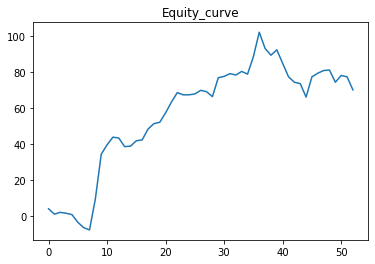

In [12]:
plt.plot(cum_p_l)
plt.title("Equity_curve")

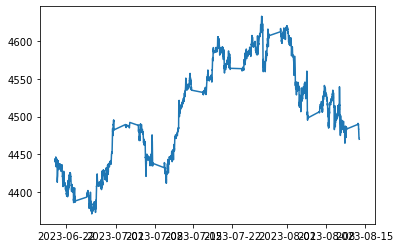

<Figure size 21600x7200 with 0 Axes>

In [13]:
plt.plot(data["Close"])
plt.figure(figsize=(300,100))
plt.show()

In [14]:
final

{'number of trades': 53,
 'Total win trades': 30,
 ' Total loose trades': 23,
 'hit ratio': 0.5660377358490566,
 'total profit': 148.75,
 'total loss': -78.75,
 'net profit': 70.0,
 'maximum_drawback': -9.0,
 'time period': Timedelta('54 days 23:45:00')}

In [15]:
sum(p_l)

70.0

In [16]:
df=data
df["p_l"]=0
temp=cum_p_l
for i in range(len(df)): 
    if int(float(df["exit_long"].iloc[i]))>0:
        df["p_l"].iloc[i]=temp[0]
        temp.pop(0)
    else: 
        df["p_l"].iloc[i]=temp[0]

ValueError: could not convert string to float: ''

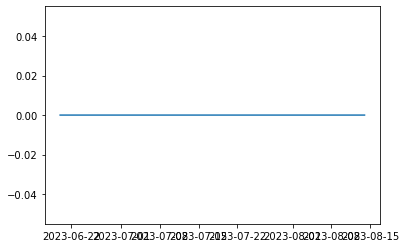

In [17]:
plt.plot(data["p_l"])

In [18]:
data

,Open,High,Low,Close,Adj Close,Volume,SMA20,UpperB,LowerB,entry_long,exit_long,stop_loss,target,trade_type,p_l
Datetime,,,,,,,,,,,,,,,
2023-06-20 00:00:00,4444.00,4444.25,4443.00,4443.75,4443.75,393,NaN,NaN,NaN,,,,,,0
2023-06-20 00:15:00,4443.50,4443.75,4443.00,4443.00,4443.00,197,NaN,NaN,NaN,,,,,,0
2023-06-20 00:30:00,4443.00,4444.00,4443.00,4443.25,4443.25,316,NaN,NaN,NaN,,,,,,0
2023-06-20 00:45:00,4443.25,4444.25,4442.00,4442.50,4442.50,762,NaN,NaN,NaN,,,,,,0
2023-06-20 01:00:00,4442.25,4443.50,4442.00,4442.50,4442.50,750,NaN,NaN,NaN,,,,,,0
2023-06-20 01:15:00,4442.25,4442.75,4438.25,4439.75,4439.75,2676,NaN,NaN,NaN,,,,,,0
2023-06-20 01:30:00,4439.50,4441.75,4439.00,4441.50,4441.50,907,NaN,NaN,NaN,,,,,,0
2023-06-20 01:45:00,4441.25,4441.75,4440.25,4441.75,4441.75,660,NaN,NaN,NaN,,,,,,0
2023-06-20 02:00:00,4441.75,4442.50,4440.00,4440.25,4440.25,1063,NaN,NaN,NaN,,,,,,0


In [19]:
p_l

[4.0,
 -3.0,
 1.0,
 -0.5,
 -0.75,
 -4.25,
 -3.0,
 -1.25,
 17.25,
 24.75,
 5.25,
 4.25,
 -0.5,
 -4.75,
 0.25,
 3.0,
 0.5,
 6.0,
 3.0,
 0.75,
 5.25,
 6.0,
 5.25,
 -1.25,
 0.0,
 0.5,
 2.0,
 -0.75,
 -2.75,
 10.5,
 0.75,
 1.5,
 -0.75,
 2.0,
 -1.5,
 9.75,
 13.5,
 -9.0,
 -3.75,
 3.0,
 -7.5,
 -7.5,
 -3.0,
 -0.75,
 -7.5,
 11.25,
 2.0,
 1.5,
 0.25,
 -6.75,
 3.75,
 -0.75,
 -7.25]